<a href="https://colab.research.google.com/github/Nandiniranga/ML_Models/blob/main/ADSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install wfdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.3/162.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import scipy
import scipy.signal
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import wfdb
from tqdm import tqdm
plt.rcParams["figure.figsize"] = (20,4)

In [3]:
wfdb.dl_database('mitdb', 'data')

Generating record list for: 100
Generating record list for: 101
Generating record list for: 102
Generating record list for: 103
Generating record list for: 104
Generating record list for: 105
Generating record list for: 106
Generating record list for: 107
Generating record list for: 108
Generating record list for: 109
Generating record list for: 111
Generating record list for: 112
Generating record list for: 113
Generating record list for: 114
Generating record list for: 115
Generating record list for: 116
Generating record list for: 117
Generating record list for: 118
Generating record list for: 119
Generating record list for: 121
Generating record list for: 122
Generating record list for: 123
Generating record list for: 124
Generating record list for: 200
Generating record list for: 201
Generating record list for: 202
Generating record list for: 203
Generating record list for: 205
Generating record list for: 207
Generating record list for: 208
Generating record list for: 209
Generati

In [4]:
!zip -r /content/mitdb.zip /content/data

  adding: content/data/ (stored 0%)
  adding: content/data/212.atr (deflated 44%)
  adding: content/data/117.atr (deflated 47%)
  adding: content/data/221.dat (deflated 32%)
  adding: content/data/104.atr (deflated 40%)
  adding: content/data/213.dat (deflated 17%)
  adding: content/data/234.dat (deflated 32%)
  adding: content/data/113.dat (deflated 29%)
  adding: content/data/214.dat (deflated 24%)
  adding: content/data/119.hea (deflated 23%)
  adding: content/data/102.hea (deflated 29%)
  adding: content/data/102.dat (deflated 24%)
  adding: content/data/234.hea (deflated 26%)
  adding: content/data/215.hea (deflated 28%)
  adding: content/data/201.atr (deflated 26%)
  adding: content/data/201.hea (deflated 26%)
  adding: content/data/101.dat (deflated 41%)
  adding: content/data/116.dat (deflated 26%)
  adding: content/data/230.dat (deflated 29%)
  adding: content/data/213.hea (deflated 34%)
  adding: content/data/210.hea (deflated 26%)
  adding: content/data/117.hea (deflated 29%

In [6]:
import scipy.signal

In [7]:
sampling_rate = 360

In [9]:
raw_sig101 = wfdb.rdrecord('data/101' , sampto = sampling_rate*30)

Text(0, 0.5, 'Amplitude (V)')

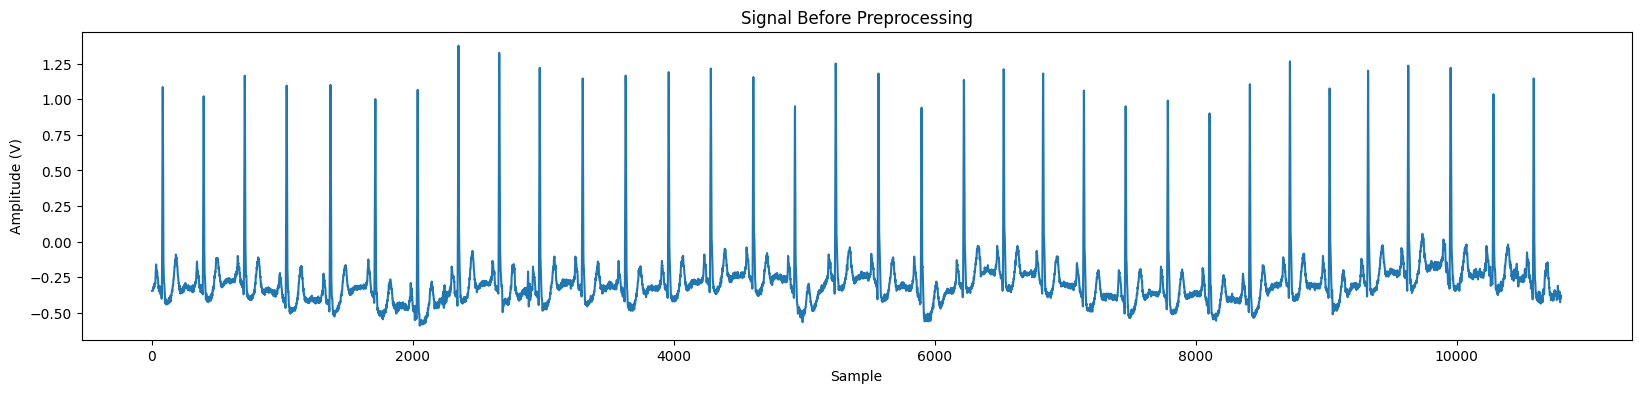

In [10]:
plt.plot(raw_sig101.p_signal[:,0])
plt.title('Signal Before Preprocessing')
plt.xlabel('Sample')
plt.ylabel('Amplitude (V)')

In [11]:
b , a = scipy.signal.butter(N = 2 , Wn = 0.5 , btype = 'highpass' , analog = False , output = 'ba' , fs = sampling_rate)

In [12]:
output1 = scipy.signal.filtfilt(b, a, raw_sig101.p_signal[:,0])

In [13]:
plt.figure()

<Figure size 2000x400 with 0 Axes>

<Figure size 2000x400 with 0 Axes>

Text(0, 0.5, 'Amplitude (V)')

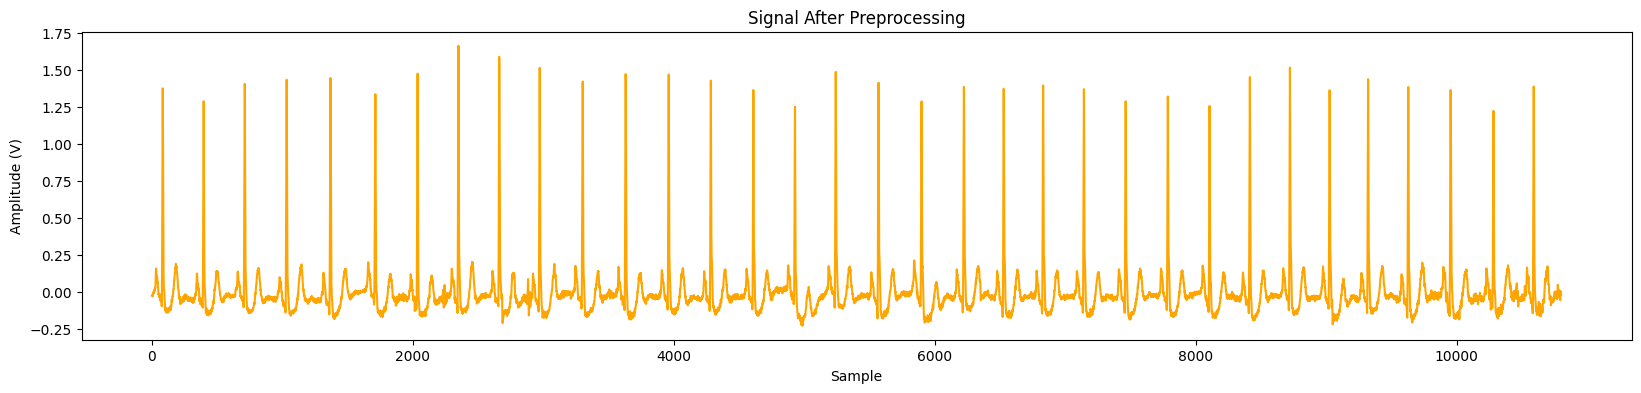

In [14]:
b2, a2 = scipy.signal.iirnotch(w0=60.0, Q=30.0, fs=360.0)
output2 = scipy.signal.filtfilt(b2, a2, output1)
plt.plot(output2, color='orange')
plt.title('Signal After Preprocessing')
plt.xlabel('Sample')
plt.ylabel('Amplitude (V)')

In [15]:
class Signal:
  def __init__(self, record, signal, r_peaks, labels):
    self.record = record # Record number
    self.signal = signal
    self.r_peaks = r_peaks
    self.labels = labels

In [16]:
invalid_labels = ['|', # Isolated QRS-like artifact
                  '~', # Change in signal quality
                  '!', # Ventricular flutter wave
                  '+', # Rhythm change
                  '[', # Start of ventricular flutter/fibrillation
                  ']', # End of ventricular flutter/fibrillation
                  '"', # Comment annotation
                  'x'  # Non-conducted P-wave (blocked APC)
                  ]

In [17]:
valid_classes = ['N', # Normal beat
                 'L', #	Left bundle branch block beat
                 'R', # Right bundle branch block beat
                 'V', # Premature ventricular contraction
                 'A', # Atrial premature beat
                 '/', # Paced Beat
                 ]

In [ ]:
def process_record(record):
  raw_signal = wfdb.rdrecord(f'data/{record}', channels = [0]).p_signal[:,0] # MLII signal only
  annotation = wfdb.rdann(f'data/{record}', extension='atr')
  r_peaks = annotation.sample
  labels = np.array( annotation.symbol)
  b, a = scipy.signal.butter(N=2, Wn=0.5, btype='highpass',
                             analog=False, output='ba', fs=sampling_rate)
  signal = scipy.signal.filtfilt(b, a, raw_signal)
  b, a = scipy.signal.iirnotch(w0=60.0, Q=30.0, fs=360.0)
  signal = scipy.signal.filtfilt(b, a, signal)
  indices = [i for (i, label) in enumerate(labels) if label not in invalid_labels]
  r_peaks, labels = r_peaks[indices], labels[indices]
  aligned_peaks = []
  for r_peak in r_peaks:
    r_left = np.maximum(r_peak - int(.05 * sampling_rate), 0)
    r_right = np.minimum(r_peak + int(.05 * sampling_rate), len(signal))
    aligned_peaks.append(r_left + np.argmax(signal[r_left:r_right]))
  r_peaks = np.array(aligned_peaks, dtype="int")
  signal = signal / np.mean(signal[r_peaks])
  return Signal(record, signal, r_peaks, labels)

In [1]:
split = True

In [ ]:
import pickle
import scipy.signal

train_ds = []
test_ds = []

if split == False:

  all_records = [100, 103, 105, 107, 111, 113, 117, 121, 123, 200, 202, 210,
                212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234,
                101, 102, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122,
                124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]

  for record_num in all_records:
    signal_data = process_record(record_num)
    train_ds.append(signal_data)

In [ ]:
if split == True:
  train_records = [101, 102, 106, 108, 109, 112, 114, 115, 116, 118, 119, 122,
              124, 201, 203, 205, 207, 208, 209, 215, 220, 223, 230]

  test_records = [100, 103, 105, 107, 111, 113, 117, 121, 123, 200, 202, 210,
            212, 213, 214, 219, 221, 222, 228, 231, 232, 233, 234]

  for record_num in train_records:
    signal_data = process_record(record_num)
    train_ds.append(signal_data)

  for record_num in test_records:
    signal_data = process_record(record_num)
    test_ds.append(signal_data)

In [ ]:
view_signal = train_ds[12]
view_len = sampling_rate*10

plt.plot(range(view_len), view_signal.signal[0:view_len])
plt.title('Record {}'.format(view_signal.record))
print('Beat Types:', view_signal.labels[0:10], '\n')

In [ ]:
print('Dataset Beat Distribution:')
total_sum = 0
for vc in valid_classes:
  sum = 0
  for sig_data in train_ds:
    for beat_label in sig_data.labels:
      if beat_label == vc:
        sum += 1
        total_sum += 1
  print(f'  {vc} - {sum}')
print(f'Total: {total_sum}')